# Machine learning - Food

Agarro 6 platos comibinados y busco como se parecen.

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist

import json
import urllib.request
import itertools
import os
import copy

from sklearn.cluster import KMeans
from lightning import Lightning

## 1. Obtener datos

Lo dicho. Hacemos la llamada y esperamos la respuesta tipo JSON con nombres, ingredientes y metodos de cocinar

``` 
HTTP GET http://donde.sea:9030/dishes/all 

HTTP RESPONSE: JSON 
[{"name":"plato combinado 1", "ingredientes": ["pollo", "patata", "pimiento"], "method": "fried"]}, {...}]

```

Yo hago un fake de esto ya que no tiene ninguna ciencia.

In [4]:
url = 'https://raw.githubusercontent.com/rafalszota/Food/master/data.json.txt'

with urllib.request.urlopen(url) as url:
    dishes = json.loads(url.read().decode())


La repuesta me da en ```dishesh``` un array de JSON como estos ejemplos:

In [5]:
dishes[0], dishes[1] 

({'cooking': ['frito'],
  'ingredients': ['pollo', 'patata', 'pimiento'],
  'name': 'plato combinado 1'},
 {'cooking': ['frito'],
  'ingredients': ['lomo', 'huevo', 'patata', 'pimiento'],
  'name': 'plato combinado 2'})

## 2. Transformar datos

Esto lo he simplificado mucho usando pandas. La idea es lo que en estadistica se llama dummy variables. En definitiva, lo dicho antes: mis criterios para ver que platos se parecen son:

1. Tienen el mismo nombre 
2. Tienen ingredientes similares
3. El metodo de coccion es el mismo (hervido, frito, al horno, etc.)

Por ahora paso de utilizar el metodo de coccion, pero la idea es la misma que los ingredientes. Por eso, aqui trabajo solo el punto 2. 

Ya lo ves, se hace bastante sencillo ya que con 3 lineas de codigo tenemos una matriz que vamos a usar para todo el concepto. 


In [6]:
names, ingredients = zip(*[(dish['name'], dish['ingredients']) for dish in dishes])
names, ingredients = pd.Series(names), pd.Series(ingredients)

df = pd.get_dummies(ingredients.apply(pd.Series).stack()).sum(level=0).set_index(names)

La matriz quedaria algo asi:

In [7]:
df

,asado completo,asado variado,huevo,lomo,morcilla,patata,pechuga pollo,pechugas,pimiento,pimiento rojo,pimiento verde,pollo,ternera,txistorra
plato combinado 1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
plato combinado 2,0,0,1,1,0,1,0,0,1,0,0,0,0,0
plato combinado 3,0,0,1,0,0,1,0,1,1,0,0,0,0,0
plato combinado 4,0,0,1,0,0,1,0,0,1,0,0,0,1,0
plato combinado 5,0,1,0,1,0,1,1,0,0,1,1,0,1,0
plato combinado 6,1,0,0,1,1,1,1,0,0,1,1,0,1,1


## 3. Ingredientes comues

#### Intro
En cuanto mas pienso, mas veo que por aqui tenia que haber empezado desde el primer momento. Junto las ideas de antes y determino ingredientes comunes.


Hay que fitrar fuera los ingredientes mas comunes. Ejemplo: todos los platos llevan sal. Pues el hecho de llevar sal no me aporta informacion addicional asi que lo puedo quitar de mi matriz de ingredientes (al menos a efectos de pareciencia).

Como de habitual son varios ingredientes? Mutiplicamos la matriz de platos e ingredientes $M$ por si misma 
y normalizamos por numero maximo de platos que tenemos. Sale algo asi:
    
$$ X = \frac{M^TM}{n} $$

donde $n$ es el numero de los rows (platos en la matriz). Esto nos da una norma para los ingredientes que aparecen juntos de manera comun. 

In [8]:
X = round(df.T.dot(df) / df.count(),2)
X

,asado completo,asado variado,huevo,lomo,morcilla,patata,pechuga pollo,pechugas,pimiento,pimiento rojo,pimiento verde,pollo,ternera,txistorra
asado completo,0.17,0.00,0.00,0.17,0.17,0.17,0.17,0.00,0.00,0.17,0.17,0.00,0.17,0.17
asado variado,0.00,0.17,0.00,0.17,0.00,0.17,0.17,0.00,0.00,0.17,0.17,0.00,0.17,0.00
huevo,0.00,0.00,0.50,0.17,0.00,0.50,0.00,0.17,0.50,0.00,0.00,0.00,0.17,0.00
lomo,0.17,0.17,0.17,0.50,0.17,0.50,0.33,0.00,0.17,0.33,0.33,0.00,0.33,0.17
morcilla,0.17,0.00,0.00,0.17,0.17,0.17,0.17,0.00,0.00,0.17,0.17,0.00,0.17,0.17
patata,0.17,0.17,0.50,0.50,0.17,1.00,0.33,0.17,0.67,0.33,0.33,0.17,0.50,0.17
pechuga pollo,0.17,0.17,0.00,0.33,0.17,0.33,0.33,0.00,0.00,0.33,0.33,0.00,0.33,0.17
pechugas,0.00,0.00,0.17,0.00,0.00,0.17,0.00,0.17,0.17,0.00,0.00,0.00,0.00,0.00
pimiento,0.00,0.00,0.50,0.17,0.00,0.67,0.00,0.17,0.67,0.00,0.00,0.17,0.17,0.00
pimiento rojo,0.17,0.17,0.00,0.33,0.17,0.33,0.33,0.00,0.00,0.33,0.33,0.00,0.33,0.17


Podemos mirar la heatmap para tener alguna intuicion, pero tampoco nos aprota algo extraordinario.

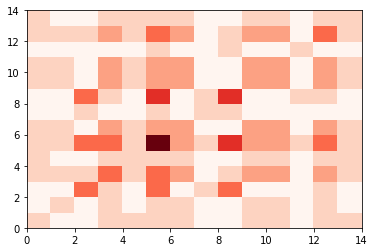

In [9]:
plt.pcolor(X, cmap=plt.cm.Reds) 
plt.show()

#### Que ingredientes no nos aportan informacion??

La diagonal de la matriz $X$ nos da los pesos de los ingredientes en si. A partir de ahora lo llamaremos vector $w$ que sera:

$$w = diag(X)$$

Si ademas lo ordenamos por pesos descendiente podemos visualizar:

In [10]:
w = np.diag(X)
pd.Series(w, index=X.index).sort_values(ascending = False)

patata            1.00
pimiento          0.67
ternera           0.50
lomo              0.50
huevo             0.50
pimiento verde    0.33
pimiento rojo     0.33
pechuga pollo     0.33
txistorra         0.17
pollo             0.17
pechugas          0.17
morcilla          0.17
asado variado     0.17
asado completo    0.17
dtype: float64

La interpretacion es de porcentaje de los platos en los que aparece. Por lo tanto la patata aparece en todos los platos (100%). 

Seguido por pimiento que aparecen 67% de los platos* 
(*ojo con discriminador: pimiento vs. pimiento verde vs. pimiento rojo - esto para luego). 

Lomo, ternera y huevo 
aparece en la mitad de todos los platos... Mas abajo aparecen ya los discriminadores.

#### Matriz de pesos normalizados


Sea W la matriz de pesos normalizados $$W = diag \bigg( \frac{w}{||w||} \bigg) $$

La diagonal dice como de habitual es un ingrediente comparando con todas las posibilidades.

- 0 no puedes ser
- si es cerca de zero, es un ingrediente muy poco habitual
- si es cerca de 1 es que aparece en absolutamente todos los platos
- si es cerca de 1 es muy habitual y por tanto no nos aporta mucha informacion.


Veamos a utilizar esta matriz para definir el concepto de los platos parecidos.

In [11]:
W = np.diag(w / sum(w))
round(pd.DataFrame(W, index=X.index, columns=X.index),4)

,asado completo,asado variado,huevo,lomo,morcilla,patata,pechuga pollo,pechugas,pimiento,pimiento rojo,pimiento verde,pollo,ternera,txistorra
asado completo,0.0328,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
asado variado,0.0000,0.0328,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
huevo,0.0000,0.0000,0.0965,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
lomo,0.0000,0.0000,0.0000,0.0965,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
morcilla,0.0000,0.0000,0.0000,0.0000,0.0328,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
patata,0.0000,0.0000,0.0000,0.0000,0.0000,0.1931,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
pechuga pollo,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0637,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
pechugas,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0328,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
pimiento,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1293,0.0000,0.0000,0.0000,0.0000,0.0000
pimiento rojo,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0637,0.0000,0.0000,0.0000,0.0000


## 4. Platos similares

#### La intuicion
Para calcular la 'pareciencia' entre los platos de momento solo utilizo los ingredientes que le componen. Lo habitual en estos casos es definir la funcion de distancia/similitud. En cuanto mas distancia mas diferente son los platos.

Sea $v$ vector binario que nos dice si un plato lleva un ingrediente o no. La funcion de pareciencia debria cumplir estas propiedades:

- Decimos que los dos platos son iguales si llevan los mismos ingredientes. 
- Decimos que los platos se parecen si los ingredientes que llevan coinciden bastante. 
- Decimos que los platos son muy distintos si comparten muy pocos ingredientes. 

Para elaborar la intuicion vamos a pensar a la inversa. 

1. Asumamos por un momento que todos los platos son iguales. 
2. Analizamos ingredientes uno por uno y para cada ingrediente que un plato lleva y otro no aumentamos un poco la distancia. 
3. Cuanto es un poco? Pues de acuerdo al peso del ingrediente. Si en genral el ingrediente es muy comun la distancia aumenta poco. Si por lo contrario el ingrediente es muy raro la distancia aumenta mas.

De esta manera obtenemos que: si dos platos tienen mucha disparidad de ingredientes poco habituales - estos platos son muy distantes. Si la disparidad no es muy grande o los ingredientes no son muy raros la distancia es menor por tanto los platos se parecen algo mas. Y si finalmente comparten la mayoria de ingredientes son muy parecidos.

#### Formalizacion

Esta intuicion se puede formalizar de la siguiente forma.

Sea $M^1$ la matriz que dice para cada plato ingredientes que lleva. Sea $M^0$ la matriz contraria - una que dice los ingredientes que un plato no lleva. Para cada plato $i$ tenemos que $M^1_i + M^0_i = 1$


In [12]:
M1 = np.matrix(df)
M0 = 1 - M1

Sea $D$ la matriz de distancia entre los platos que definimos de la siguiente manera:
    
$$ D = M^1 W \, (M^0)^T + M^0 W \, (M^1)^T $$

La matriz $D$ tiene las propiedades tal que:

- $D_{ij} = D_{ji}$ lo que representa la distancia enre los platos $i$ e $j$
- La matriz esta normalizada, o sea: $\forall_{ij} \; 0 \geq D_{ij} \geq 1 $
- Cada plato es identico a si mismo: $D_{ii} = 1$

La matriz contraria de $D$ definomos como $S = 1-D$ y consideramos como similitud entre lso platos. Podemos construir el data frame de la matriz que llamaremos: *dish_similarity*


In [13]:
D = (M1.dot(W).dot(M0.T) + M0.dot(W).dot(M1.T))

S = 1 - D

dish_similarity = round(pd.DataFrame(S, columns=names, index=names),3)
dish_similarity

,plato combinado 1,plato combinado 2,plato combinado 3,plato combinado 4,plato combinado 5,plato combinado 6
plato combinado 1,1.000,0.774,0.838,0.774,0.421,0.355
plato combinado 2,0.774,1.000,0.871,0.807,0.454,0.388
plato combinado 3,0.838,0.871,1.000,0.871,0.324,0.259
plato combinado 4,0.774,0.807,0.871,1.000,0.454,0.388
plato combinado 5,0.421,0.454,0.324,0.454,1.000,0.869
plato combinado 6,0.355,0.388,0.259,0.388,0.869,1.000


Ahora utilizando el heatmap si que vemos bastante claro los clusters de los platos similares

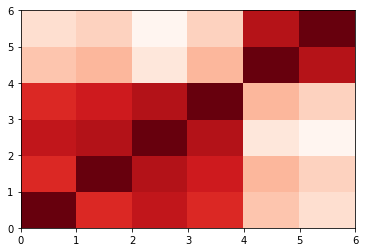

In [14]:
plt.pcolor(dish_similarity, cmap=plt.cm.Reds)
plt.show()

### 5. Machine Learning

Teniendo una definicion formal podemos empezar a jugar con el machine learning de verdad. Sigo usando el K-means para agrupar los platos.

Queremos tener ```n_clusters=3``` grupos.

In [17]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(dish_similarity)

gropped_dishes = pd.DataFrame({"name": names, "group": kmeans.labels_})
#gropped_dishes = gropped_dishes.sort_values("group").set_index("group")
gropped_dishes

,group,name
0,0,plato combinado 1
1,2,plato combinado 2
2,2,plato combinado 3
3,2,plato combinado 4
4,1,plato combinado 5
5,1,plato combinado 6


Cosa que no sorprende haber visto el heatmap. Hay:

- Un cluster del plato 1 que es muy basico
- Segundo cluster de los platos 5 y 6 que se parecen
- Tercer cluster de los platos 2, 3 y 4 que tambien se parecen


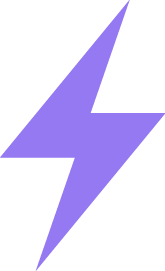

Connected to server at http://public.lightning-viz.org


<IPython.core.display.Javascript object>

In [27]:
lgn = Lightning(ipython=True, host='http://public.lightning-viz.org')

clusters = copy.deepcopy(dish_similarity)
clusters[clusters<0.8] = 0
lgn.force(clusters, group = kmeans.labels_) 

## 5. Sistema de Recomendacion 

Sabiendo los platos parecidos podemos montar un sistema de recomendacion. Si te gusta este plato quizas tambien te 
gustaría este otro. Seria algo asi como: Para cada plato dame 3 platos que se le parecen y se lo recomendamos 
a la persona.

In [14]:
recomender_names = ['Original dish', 'Recommend 1', 'Recommend 2', 'Recommend 3']
recomendations = pd.DataFrame([dish_similarity.ix[i].sort_values(ascending=False)[0:4].index for i in range(6)], columns = recomender_names)
recomendations = recomendations.set_index('Original dish')
recomendations

,Recommend 1,Recommend 2,Recommend 3
Original dish,,,
plato combinado 1,plato combinado 3,plato combinado 4,plato combinado 2
plato combinado 2,plato combinado 3,plato combinado 4,plato combinado 1
plato combinado 3,plato combinado 4,plato combinado 2,plato combinado 1
plato combinado 4,plato combinado 3,plato combinado 2,plato combinado 1
plato combinado 5,plato combinado 6,plato combinado 4,plato combinado 2
plato combinado 6,plato combinado 5,plato combinado 4,plato combinado 2
